In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 700


### Create dataloder

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [5]:
len(dataloader)

3750

In [6]:
for image, cat in dataloader:
    break

In [7]:
image.size()

torch.Size([16, 1, 28, 28])

In [8]:
28*28

784

### Create generator and discriminator

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [10]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [11]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [12]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

### Задание

1) Посмотрите на реализацию GAN. Постройте интерполяцию между какими-нибудь двумя сгенерированными картинками. (Опционально)Добавьте свертки в генератор и дискриминатор, как в статье про DCGAN.

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Добавьте к обучению GAN условие на метку, продемонстрируйте условную генерацию. https://arxiv.org/pdf/1411.1784.pdf

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

В каждом пункте постройте графики функций потерь.

### GAN

In [13]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(torch.squeeze(output), label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(torch.squeeze(output), label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(torch.squeeze(output), label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 700 errD_x: 0.03 errD_z: 0.05 errG: 3.24
Epoch:1 Iter: 1400 errD_x: 0.21 errD_z: 0.09 errG: 2.98
Epoch:1 Iter: 2100 errD_x: 0.24 errD_z: 0.17 errG: 2.46
Epoch:1 Iter: 2800 errD_x: 0.02 errD_z: 0.07 errG: 3.34
Epoch:1 Iter: 3500 errD_x: 0.10 errD_z: 0.03 errG: 4.12
Epoch:2 Iter: 700 errD_x: 0.24 errD_z: 0.06 errG: 3.27
Epoch:2 Iter: 1400 errD_x: 0.02 errD_z: 0.09 errG: 3.08
Epoch:2 Iter: 2100 errD_x: 0.33 errD_z: 0.10 errG: 2.03
Epoch:2 Iter: 2800 errD_x: 0.21 errD_z: 0.22 errG: 2.23
Epoch:2 Iter: 3500 errD_x: 0.10 errD_z: 0.11 errG: 2.88
Epoch:3 Iter: 700 errD_x: 0.16 errD_z: 0.23 errG: 2.35
Epoch:3 Iter: 1400 errD_x: 0.52 errD_z: 0.09 errG: 2.63
Epoch:3 Iter: 2100 errD_x: 0.00 errD_z: 0.04 errG: 3.98
Epoch:3 Iter: 2800 errD_x: 0.17 errD_z: 0.13 errG: 3.16
Epoch:3 Iter: 3500 errD_x: 0.23 errD_z: 0.13 errG: 2.01
Epoch:4 Iter: 700 errD_x: 0.08 errD_z: 0.26 errG: 2.19
Epoch:4 Iter: 1400 errD_x: 0.09 errD_z: 0.32 errG: 1.81
Epoch:4 Iter: 2100 errD_x: 0.15 errD_z: 0.01 errG: 5

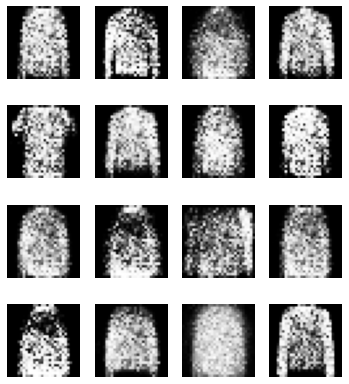

In [14]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

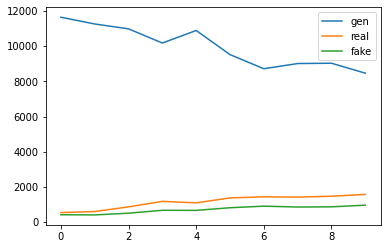

In [15]:
plt.plot(figsize = (12,7))
plt.plot(ERRG, label = "gen")
plt.plot(ERRD_x, label = "real")
plt.plot(ERRD_z, label = "fake")
plt.legend()
plt.show()

### 1. Интерполяция между двумя сгенерированными картинками

(googled this solution - https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/)

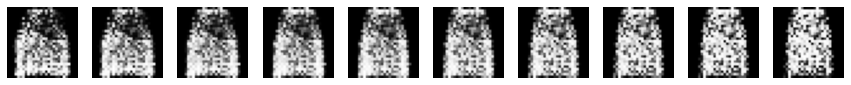

In [16]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)
    
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

# create a plot of generated images
def plot_generated(examples, n):
    plt.figure(figsize=(15, 5))
    # plot images
    for i in range(n):
        # define subplot
        plt.subplot(1, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.show()

# generate points in latent space
pts = generate_latent_points(config.noise_size, 2)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])
# generate images
X = generator(torch.FloatTensor(interpolated))
# plot the result
plot_generated(X, len(interpolated))

### 2. LSGAN

In [17]:
generator = Generator()
discriminator = Discriminator()

In [18]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.MSELoss() # change BCE to MSE

In [19]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [20]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(torch.squeeze(output), label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(torch.squeeze(output), label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(torch.squeeze(output), label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 700 errD_x: 0.01 errD_z: 0.01 errG: 0.86
Epoch:1 Iter: 1400 errD_x: 0.30 errD_z: 0.02 errG: 0.78
Epoch:1 Iter: 2100 errD_x: 0.06 errD_z: 0.06 errG: 0.90
Epoch:1 Iter: 2800 errD_x: 0.10 errD_z: 0.03 errG: 0.76
Epoch:1 Iter: 3500 errD_x: 0.06 errD_z: 0.02 errG: 0.80
Epoch:2 Iter: 700 errD_x: 0.06 errD_z: 0.04 errG: 0.78
Epoch:2 Iter: 1400 errD_x: 0.13 errD_z: 0.01 errG: 0.86
Epoch:2 Iter: 2100 errD_x: 0.02 errD_z: 0.03 errG: 0.83
Epoch:2 Iter: 2800 errD_x: 0.05 errD_z: 0.07 errG: 0.74
Epoch:2 Iter: 3500 errD_x: 0.01 errD_z: 0.14 errG: 0.69
Epoch:3 Iter: 700 errD_x: 0.09 errD_z: 0.11 errG: 0.65
Epoch:3 Iter: 1400 errD_x: 0.24 errD_z: 0.03 errG: 0.77
Epoch:3 Iter: 2100 errD_x: 0.19 errD_z: 0.01 errG: 0.92
Epoch:3 Iter: 2800 errD_x: 0.02 errD_z: 0.08 errG: 0.77
Epoch:3 Iter: 3500 errD_x: 0.02 errD_z: 0.09 errG: 0.63
Epoch:4 Iter: 700 errD_x: 0.16 errD_z: 0.11 errG: 0.78
Epoch:4 Iter: 1400 errD_x: 0.02 errD_z: 0.07 errG: 0.70
Epoch:4 Iter: 2100 errD_x: 0.12 errD_z: 0.03 errG: 0

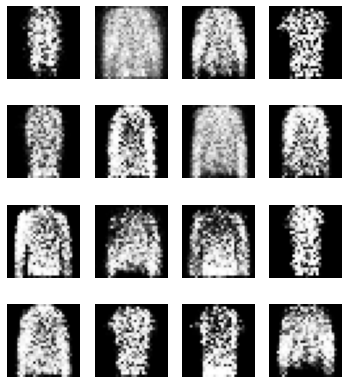

In [21]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

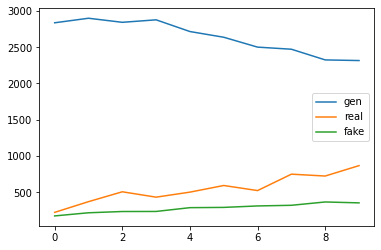

In [22]:
plt.plot(figsize = (12,7))
plt.plot(ERRG, label = "gen")
plt.plot(ERRD_x, label = "real")
plt.plot(ERRD_z, label = "fake")
plt.legend()
plt.show()

### 3. Условная генерация

In [23]:
class ConditionalGenerator(nn.Module):
    def __init__(self):
      super(ConditionalGenerator, self).__init__()
      self.model = nn.Sequential(
          nn.Linear(config.noise_size + 10, 200),
          nn.ReLU(inplace=True),
          nn.Linear(200, 28*28),
          nn.Sigmoid())
      self.label_emb = nn.Embedding(10, 10)
        
    def forward(self, x, labels):
      c = self.label_emb(labels)
      x = torch.cat([x,c], 1)
      return self.model(x)
    
class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(ConditionalDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28 + 10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
        self.label_emb = nn.Embedding(10, 10)
        
    def forward(self, x, labels):
      c = self.label_emb(labels)
      x = torch.cat([x,c], 1)
      return self.model(x)

In [24]:
generator = ConditionalGenerator()
discriminator = ConditionalDiscriminator()

In [25]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

In [26]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [27]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data, cat)
        errD_x = criterion(torch.squeeze(output), label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        fake_cat = Variable(torch.LongTensor(np.random.randint(0, 10, config.batch_size)))
        noise.data.normal_(0, 1)
        label.data.fill_(fake_label)
        fake = generator(noise, fake_cat)
        output = discriminator(fake.detach(), fake_cat)
        errD_z = criterion(torch.squeeze(output), label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake, fake_cat)
        errG = criterion(torch.squeeze(output), label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 700 errD_x: 0.21 errD_z: 0.16 errG: 2.14
Epoch:1 Iter: 1400 errD_x: 0.13 errD_z: 0.19 errG: 2.58
Epoch:1 Iter: 2100 errD_x: 0.08 errD_z: 0.10 errG: 3.50
Epoch:1 Iter: 2800 errD_x: 0.08 errD_z: 0.06 errG: 4.33
Epoch:1 Iter: 3500 errD_x: 0.01 errD_z: 0.00 errG: 7.26
Epoch:2 Iter: 700 errD_x: 0.04 errD_z: 0.07 errG: 3.60
Epoch:2 Iter: 1400 errD_x: 0.09 errD_z: 0.02 errG: 4.26
Epoch:2 Iter: 2100 errD_x: 0.04 errD_z: 0.07 errG: 3.48
Epoch:2 Iter: 2800 errD_x: 0.02 errD_z: 0.02 errG: 5.76
Epoch:2 Iter: 3500 errD_x: 0.16 errD_z: 0.06 errG: 3.60
Epoch:3 Iter: 700 errD_x: 0.06 errD_z: 0.02 errG: 5.21
Epoch:3 Iter: 1400 errD_x: 0.22 errD_z: 0.02 errG: 6.42
Epoch:3 Iter: 2100 errD_x: 0.02 errD_z: 0.16 errG: 4.67
Epoch:3 Iter: 2800 errD_x: 0.03 errD_z: 0.08 errG: 4.96
Epoch:3 Iter: 3500 errD_x: 0.14 errD_z: 0.07 errG: 3.73
Epoch:4 Iter: 700 errD_x: 0.36 errD_z: 0.01 errG: 5.18
Epoch:4 Iter: 1400 errD_x: 0.34 errD_z: 0.01 errG: 5.36
Epoch:4 Iter: 2100 errD_x: 0.28 errD_z: 0.28 errG: 2

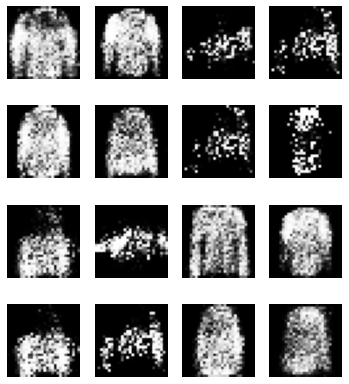

In [28]:
noise.data.normal_(0, 1)
fake_cat = torch.LongTensor(np.random.randint(0, 10, config.batch_size))

fake = generator(noise, fake_cat)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

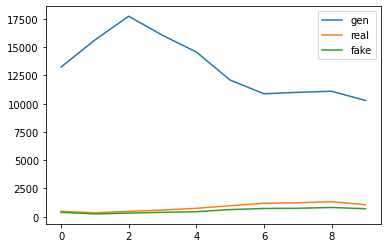

In [29]:
plt.plot(figsize = (12,7))
plt.plot(ERRG, label = "gen")
plt.plot(ERRD_x, label = "real")
plt.plot(ERRD_z, label = "fake")
plt.legend()
plt.show()